# Imports

In [2]:
import os
import logging
import importlib
importlib.reload(logging)
log = logging.getLogger()
log.setLevel('INFO')
import sys

logging.basicConfig(format='%(asctime)s %(levelname)s |: %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import mne
from mne.io import concatenate_raws
import matplotlib.pyplot as plt
from scipy import signal
from sklearn import preprocessing
import numpy as np
from torchsummary import summary
import torch

from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.torch_ext.optimizers import AdamW
import torch.nn.functional as F
from braindecode.models.deep4 import Deep4Net
import pickle

ImportError: cannot import name '_check_windowing_arguments' from partially initialized module 'braindecode.datautil.windowers' (most likely due to a circular import) (/home/mateusz_personal/.local/lib/python3.8/site-packages/braindecode/datautil/windowers.py)

# Data processing

In [10]:
path = './processed_data/'
data_type = 'XDAWN_divided'
X_pseudo_test = np.load(path + f'X_pseudo_test_{data_type}.npy', )
X_word_test = np.load(path + f'X_word_test_{data_type}.npy', )
X_pseudo_train = np.load(path + f'X_pseudo_train_{data_type}.npy', )
X_word_train = np.load(path + f'X_word_train_{data_type}.npy', )
try:
    X_pseudo_valid = np.load(path + f'X_pseudo_valid_{data_type}.npy', )
    X_word_valid = np.load(path + f'X_word_valid_{data_type}.npy', )
except:
    print('No validation data provided')

In [63]:
X_test = np.concatenate((X_word_test,X_pseudo_test))
X_test = (X_test * 1e8).astype(np.float32)
y_test = np.zeros(X_test.shape[0])
y_test[:X_word_test.shape[0]] = 1
ind = np.arange(X_test.shape[0])
np.random.shuffle(ind)
X_test = X_test[ind,:,:]
y_test = y_test[ind]

X_train = np.concatenate((X_word_train,X_pseudo_train))
X_train = (X_train * 1e8).astype(np.float32)
y_train = np.zeros(X_train.shape[0])
y_train[:X_word_train.shape[0]] = 1
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)
X_train = X_train[ind,:,:]
y_train = y_train[ind]

y_test = y_test.astype(np.int64)
y_train = y_train.astype(np.int64)

try:
    X_valid = np.concatenate((X_word_valid,X_pseudo_valid))
    X_valid = (X_valid * 1e8).astype(np.float32)
    y_valid = np.zeros(X_valid.shape[0])
    y_valid[:X_word_valid.shape[0]] = 0
    y_valid[X_word_valid.shape[0]:] = 1
    ind = np.arange(X_valid.shape[0])
    np.random.shuffle(ind)
    X_valid = X_valid[ind,:,:]
    y_valid = y_valid[ind]

    y_valid = y_valid.astype(np.int64)
except:
    print('No validation data provided')

In [64]:
print(f'X_train; {X_train.shape}')
print(f'y_train; {y_train.shape}')
print(f'X_test; {X_test.shape}')
print(f'y_test; {y_test.shape}')
try:
    print(f'X_valid; {X_valid.shape}')
    print(f'y_valid; {y_valid.shape}')
    print(X_valid.shape[0]+X_test.shape[0]+X_train.shape[0])
except:
    print('No validation data provided')

X_train; (12688, 19, 306)
y_train; (12688,)
X_test; (3988, 19, 306)
y_test; (3988,)
X_valid; (1387, 19, 306)
y_valid; (1387,)
18063


In [68]:
train_set = SignalAndTarget(X_train, y=y_train)
valid_set = SignalAndTarget(X_test, y=y_test)

# Data processing per participant

In [52]:
# path = './processed_data/'
# data_type = 'XDAWN_per_participant'
# X_pseudo = np.load(path + f'X_pseudo_{data_type}.npy', allow_pickle=True)
# X_word = np.load(path + f'X_word_{data_type}.npy', allow_pickle=True)

# X_pseudo_train = np.concatenate(X_pseudo[1:12], axis=0)
# X_word_train = np.concatenate(X_word[1:12], axis=0)

# X_pseudo_test = np.concatenate(X_pseudo[[15,17,18,20,21,22,24]], axis=0)
# X_pseudo_test = np.concatenate([X_pseudo_test, np.concatenate(X_pseudo[26:], axis=0)], axis=0)
# X_word_test = np.concatenate(X_word[[15,17,18,20,21,22,24]], axis=0)
# X_word_test = np.concatenate([X_word_test, np.concatenate(X_word[26:], axis=0)], axis=0)

# X_pseudo_valid = X_pseudo[12:]
# X_word_valid = X_word[12:]

In [34]:
path = './processed_data/'
data_type = 'XDAWN_per_participant'
X_pseudo = np.load(path + f'X_pseudo_{data_type}.npy', allow_pickle=True)
X_word = np.load(path + f'X_word_{data_type}.npy', allow_pickle=True)

for participant_id in range(0, len(X_pseudo)):
    if X_pseudo[participant_id] is not None:
        for channel in range(0, X_pseudo[participant_id].shape[1]):
            X_pseudo[participant_id][:,channel,:] = preprocessing.scale(X_pseudo[participant_id][:,channel,:]) #normalization
        
for participant_id in range(0, len(X_word)):
    if X_word[participant_id] is not None:
        for channel in range(0, X_word[participant_id].shape[1]):
            X_word[participant_id][:,channel,:] = preprocessing.scale(X_word[participant_id][:,channel,:]) #normalization
    

X_pseudo_test = np.concatenate(X_pseudo[1:12], axis=0)
X_word_test = np.concatenate(X_word[1:12], axis=0)

X_pseudo_train = np.concatenate(X_pseudo[[15,17,18,20,21,22,24]], axis=0)
X_pseudo_train = np.concatenate([X_pseudo_train, np.concatenate(X_pseudo[26:], axis=0)], axis=0)
X_word_train = np.concatenate(X_word[[15,17,18,20,21,22,24]], axis=0)
X_word_train = np.concatenate([X_word_train, np.concatenate(X_word[26:], axis=0)], axis=0)

X_pseudo_valid = X_pseudo[:12]
X_word_valid = X_word[:12]

In [35]:
# X_pseudo_train_list = []
# for i in X_pseudo_train:
#     if i is not None:
#         X_pseudo_train_list.append(i)
# X_pseudo_train = np.array(X_pseudo_train_list, dtype=object)
# del X_pseudo_train_list

In [36]:
# X_word_train_list = []
# for i in X_word_train:
#     if i is not None:
#         X_word_train_list.append(i)
# X_word_train = np.array(X_word_train_list, dtype=object)
# del X_word_train_list

In [37]:
X_test = np.concatenate((X_word_test,X_pseudo_test))
X_test = (X_test * 1e2).astype(np.float32)
y_test = np.zeros(X_test.shape[0])
y_test[:X_word_test.shape[0]] = 1
ind = np.arange(X_test.shape[0])
np.random.shuffle(ind)
X_test = X_test[ind,:,:]
y_test = y_test[ind]

X_train = np.concatenate((X_word_train,X_pseudo_train))
X_train = (X_train * 1e2).astype(np.float32)
y_train = np.zeros(X_train.shape[0])
y_train[:X_word_train.shape[0]] = 1
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)
X_train = X_train[ind,:,:]
y_train = y_train[ind]

y_test = y_test.astype(np.int64)
y_train = y_train.astype(np.int64)

In [38]:
X_pseudo_valid_list = []
y_pseudo_valid_list = []
for i in X_pseudo_valid:
    if i is not None:
        X_pseudo_valid_list.append((i* 1e2).astype(np.float32))
        y_pseudo_valid_list.append(np.zeros(i.shape[0]).astype(np.int64))
X_pseudo_valid = np.array(X_pseudo_valid_list, dtype=object)
y_pseudo_valid = np.array(y_pseudo_valid_list, dtype=object)
del X_pseudo_valid_list
del y_pseudo_valid_list

In [39]:
X_word_valid_list = []
y_word_valid_list = []
for i in X_word_valid:
    if i is not None:
        X_word_valid_list.append((i* 1e2).astype(np.float32))
        y_word_valid_list.append(np.ones(i.shape[0]).astype(np.int64))
X_word_valid = np.array(X_word_valid_list, dtype=object)
y_word_valid = np.array(y_word_valid_list, dtype=object)
del X_word_valid_list
del y_word_valid_list

In [40]:
train_set = SignalAndTarget(X_train, y=y_train)
valid_set = SignalAndTarget(X_test, y=y_test)

In [41]:
X_train.shape

(11330, 19, 306)

In [42]:
X_test.shape

(6733, 19, 306)

In [76]:
np.abs(X_train[:,0,:]).shape

(11330, 306)

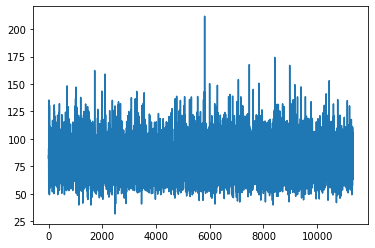

In [82]:
plt.plot(np.mean(np.abs(X_train[:,0,:]), axis=1))

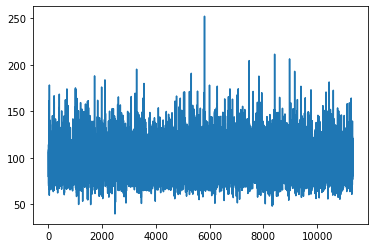

In [88]:
plt.plot(np.std(X_train[:,0,:], axis=1))

# ShallowFBCSPNet model

In [91]:
# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = True
set_random_seeds(seed=20170629, cuda=cuda)
set_random_seeds(seed=100, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1]
# final_conv_length = auto ensures we only get a single output in the time dimension
model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=train_set.X.shape[2],
                        final_conv_length='auto')
if cuda:
    model.cuda()
    

optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
# optimizer = AdamW(model.parameters(), lr=0.0625 * 0.01, weight_decay=0)
model.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1,)

In [92]:
model.fit(train_set.X, train_set.y, epochs=10, batch_size=16, scheduler='cosine',
         validation_data=(valid_set.X, valid_set.y),)

2020-05-22 11:00:11,711 INFO |: Run until first stop...
2020-05-22 11:00:13,428 INFO |: Epoch 0
2020-05-22 11:00:13,429 INFO |: train_loss                9.54790
2020-05-22 11:00:13,429 INFO |: valid_loss                9.58253
2020-05-22 11:00:13,430 INFO |: train_misclass            0.50335
2020-05-22 11:00:13,430 INFO |: valid_misclass            0.51344
2020-05-22 11:00:13,430 INFO |: runtime                   0.00000
2020-05-22 11:00:13,431 INFO |: 
2020-05-22 11:00:21,726 INFO |: Time only for training updates: 8.29s
2020-05-22 11:00:23,268 INFO |: Epoch 1
2020-05-22 11:00:23,269 INFO |: train_loss                0.45173
2020-05-22 11:00:23,269 INFO |: valid_loss                0.81553
2020-05-22 11:00:23,270 INFO |: train_misclass            0.21765
2020-05-22 11:00:23,270 INFO |: valid_misclass            0.42566
2020-05-22 11:00:23,271 INFO |: runtime                   10.01447
2020-05-22 11:00:23,271 INFO |: 
2020-05-22 11:00:31,557 INFO |: Time only for training updates: 8.2

KeyboardInterrupt: 

In [30]:
model_path = './models/'
torch.save(model.network, model_path + f'ShallowFBCSPNet_{data_type}')

In [31]:
model_path = './models/'
pickle_out = open(model_path + f'ShallowFBCSPNet_{data_type}.pickle',"wb")
pickle.dump(model, pickle_out)

/home/mateusz_personal/.local/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [20]:
try:
    validation_set = SignalAndTarget(X=X_valid, y=y_valid)
    print(model.evaluate(validation_set.X, validation_set.y))
except:
    print('No validation data provided')

No validation data provided


In [66]:
misclass_sum = 0
for i in range(0, X_word_valid.shape[0]):
    validation_set = SignalAndTarget(X=X_word_valid[i], y=y_word_valid[i])
    print(model.evaluate(validation_set.X, validation_set.y)['misclass'])
    print(model.predict_classes(validation_set.X[:20]))
    print(validation_set.y[:20])
    misclass_sum += model.evaluate(validation_set.X, validation_set.y)['misclass']
misclass_sum/X_pseudo_valid.shape[0]

0.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.038461538461538436
[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.22368421052631582
[0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.0030674846625766694
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.37579617834394907
[1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.5360230547550433
[0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0

0.10700295152267483

In [67]:
misclass_sum = 0
for i in range(0, X_pseudo_valid.shape[0]):
    validation_set = SignalAndTarget(X=X_pseudo_valid[i], y=y_pseudo_valid[i])
    print(model.evaluate(validation_set.X, validation_set.y)['misclass'])
    print(model.predict_classes(validation_set.X[:20]))
    print(validation_set.y[:20])
    misclass_sum += model.evaluate(validation_set.X, validation_set.y)['misclass']
misclass_sum/X_pseudo_valid.shape[0]

0.9148351648351648
[0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.891566265060241
[0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.06643356643356646
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.39649122807017545
[0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.6770833333333333
[1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.7456647398843931
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.014245014245014231
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.0057803468

0.5192817871529725

In [68]:
misclass_sum = 0
for i in range(0, X_pseudo_valid.shape[0]):
    validation_set = SignalAndTarget(X=X_pseudo_valid[i], y=y_pseudo_valid[i])
    pseudo = (model.evaluate(validation_set.X, validation_set.y)['misclass'])
    validation_set = SignalAndTarget(X=X_word_valid[i], y=y_word_valid[i])
    word = (model.evaluate(validation_set.X, validation_set.y)['misclass'])
    print(f'{i}: pseudo: {round(pseudo, 2)}, word: {round(word, 2)}')

0: pseudo: 0.91, word: 0.0
1: pseudo: 0.89, word: 0.0
2: pseudo: 1.0, word: 0.0
3: pseudo: 1.0, word: 0.04
4: pseudo: 0.07, word: 0.0
5: pseudo: 0.0, word: 0.22
6: pseudo: 0.4, word: 0.0
7: pseudo: 0.68, word: 0.0
8: pseudo: 0.75, word: 0.0
9: pseudo: 0.01, word: 0.38
10: pseudo: 0.01, word: 0.54


In [21]:
alpha_test = np.mean(X_pseudo_valid[2], axis=0)
alpha_test_x = np.mean(X_pseudo_valid[0], axis=0)

In [26]:
frex, px = signal.welch(alpha_test, fs=256)
frex, pxx = signal.welch(alpha_test_x, fs=256)

In [27]:
px.shape

(19, 129)

# Średnie potencjały!
# Normalizacja
# Przeuczanie

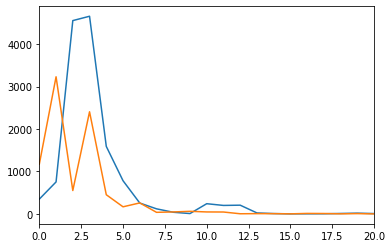

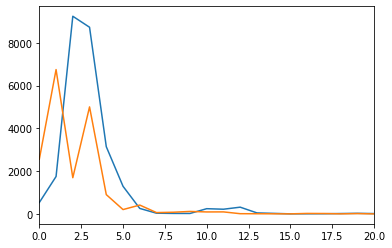

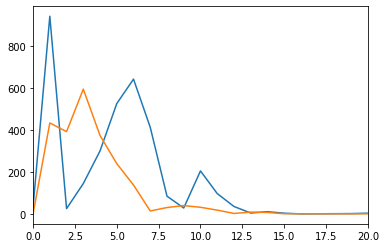

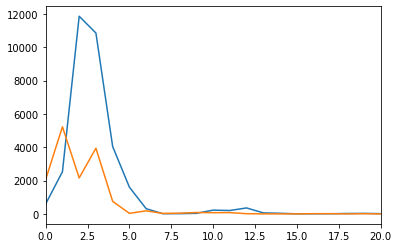

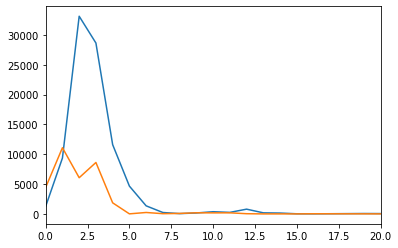

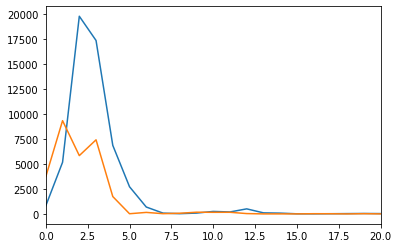

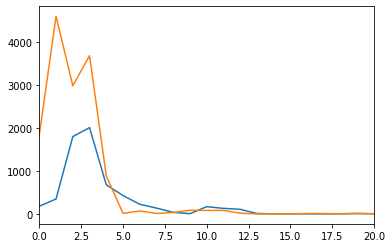

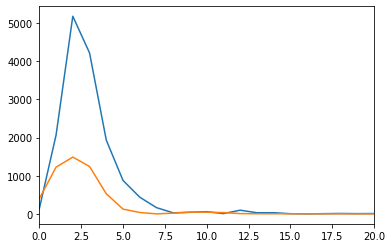

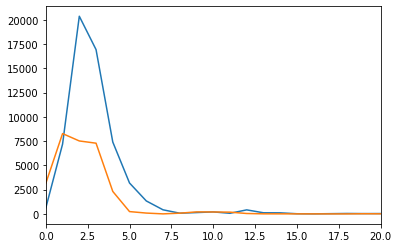

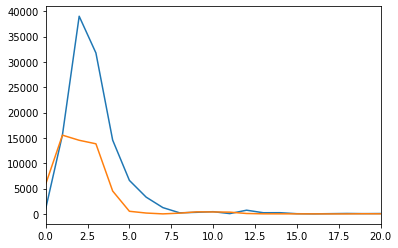

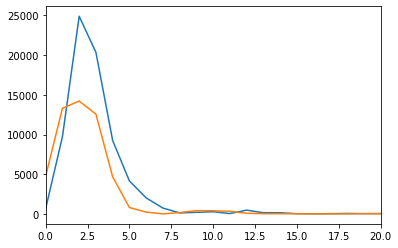

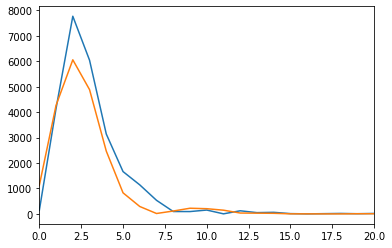

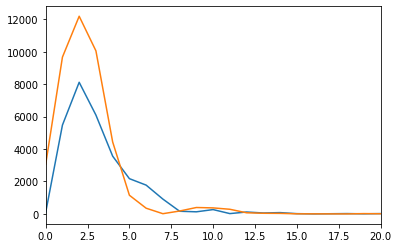

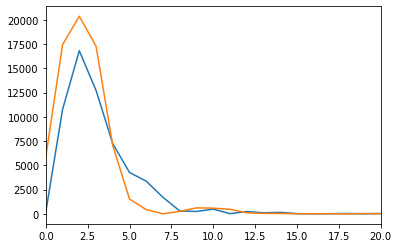

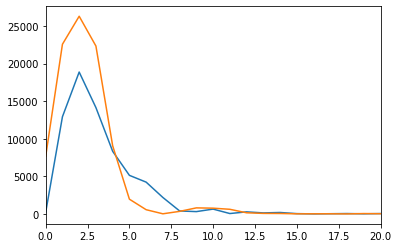

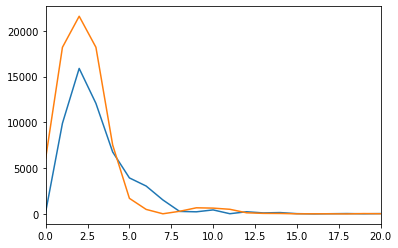

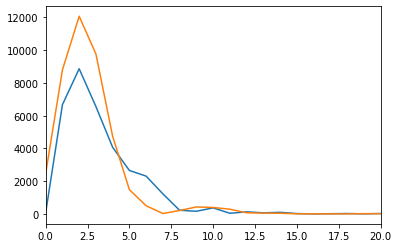

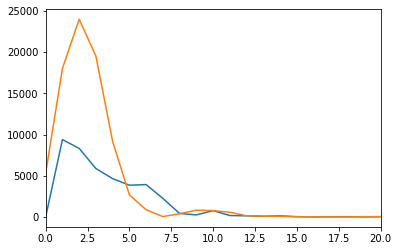

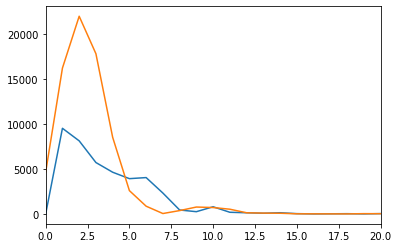

In [28]:
for i in range(0,19):
    plt.plot(frex, px[i])
    plt.plot(frex, pxx[i])
    plt.xlim(0,20)
    plt.show()

# Deep4Net model

In [64]:
# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = True
set_random_seeds(seed=20170629, cuda=cuda)

# This will determine how many crops are processed in parallel
input_time_length = 306
# final_conv_length determines the size of the receptive field of the ConvNet
model = Deep4Net(in_chans=19, n_classes=2, input_time_length=input_time_length,
                 filter_length_3=5, filter_length_4=5,
                 pool_time_stride=2,
                 stride_before_pool=True,
                        final_conv_length=1)
if cuda:
    model.cuda()
    
optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
model.compile(loss=F.nll_loss, optimizer=optimizer,  iterator_seed=1, cropped=True)

In [65]:
input_time_length = 306
model.fit(train_set.X, train_set.y, epochs=1, batch_size=8, scheduler='cosine',
          input_time_length=input_time_length,
         validation_data=(valid_set.X, valid_set.y),)

2020-05-22 10:17:17,681 INFO |: Run until first stop...
2020-05-22 10:17:23,192 INFO |: Epoch 0
2020-05-22 10:17:23,193 INFO |: train_loss                4.27835
2020-05-22 10:17:23,193 INFO |: valid_loss                4.24856
2020-05-22 10:17:23,194 INFO |: train_misclass            0.50485
2020-05-22 10:17:23,194 INFO |: valid_misclass            0.51463
2020-05-22 10:17:23,194 INFO |: runtime                   0.00000
2020-05-22 10:17:23,195 INFO |: 
2020-05-22 10:17:50,843 INFO |: Time only for training updates: 27.07s
2020-05-22 10:17:56,668 INFO |: Epoch 1
2020-05-22 10:17:56,669 INFO |: train_loss                0.39017
2020-05-22 10:17:56,669 INFO |: valid_loss                0.61328
2020-05-22 10:17:56,670 INFO |: train_misclass            0.16708
2020-05-22 10:17:56,670 INFO |: valid_misclass            0.32630
2020-05-22 10:17:56,670 INFO |: runtime                   33.16162
2020-05-22 10:17:56,671 INFO |: 


In [32]:
sum(validation_set.y)

671